In [344]:
# Importing libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, TimeSeriesSplit
from skopt import BayesSearchCV
from skopt.plots import plot_convergence





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB
None


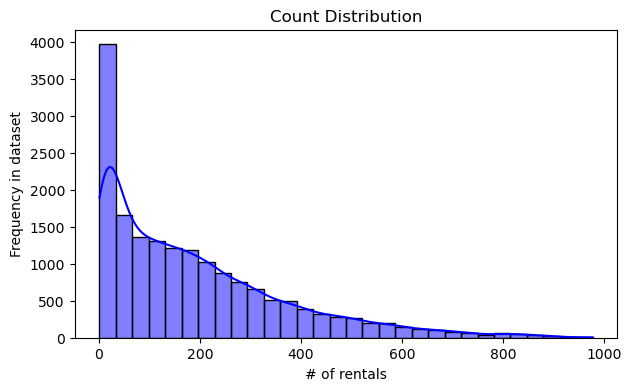

Cnt max 977
Cnt min 1
Max count 1
Min count 158


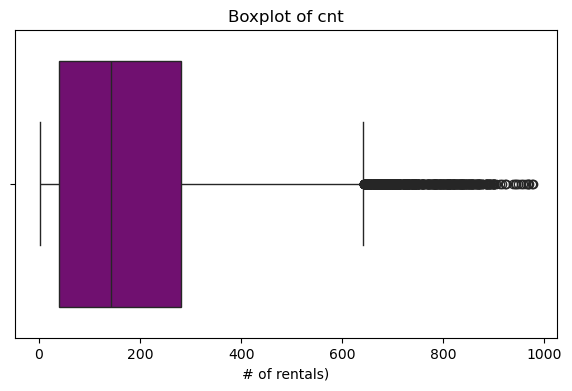

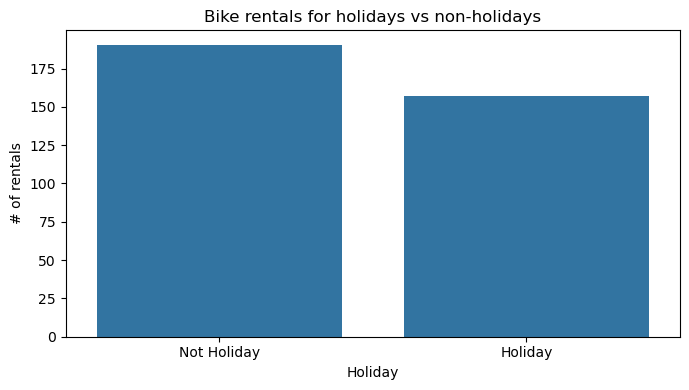

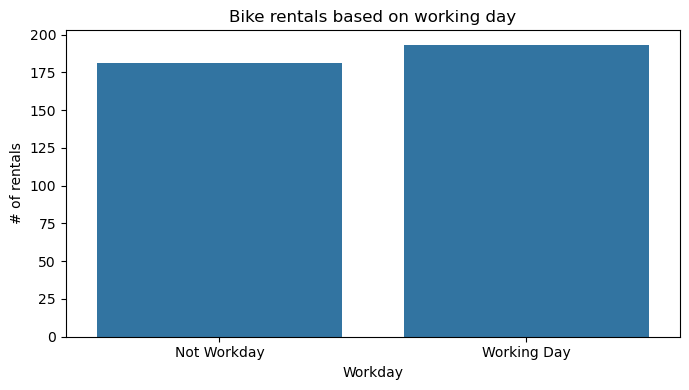


Rentals based on weekday:
Weekday with the most rentals: Friday 487790
Weekday with the least rentals: Sunday 444027

Rentals based on weather situation:
weathersit
1    2338173
2     795952
3     158331
4        223
Name: cnt, dtype: int64
           temp     atemp
temp   1.000000  0.987672
atemp  0.987672  1.000000
          temp       hum
temp  1.000000 -0.069881
hum  -0.069881  1.000000


In [384]:
# Task 1: Exploratory Data Analysis

# loading data into DataFrame
df = pd.read_csv("/Users/clairestewart/ML-fundamentals-2025/bike+sharing+dataset/hour.csv")
df.head()
print(df.info())


# cnt distribution
plt.figure(figsize=(7, 4))
sns.histplot(df['cnt'], kde=True, bins=30, color='blue')
plt.title('Count Distribution', fontsize=12)
plt.xlabel('# of rentals', fontsize=10)
plt.ylabel('Frequency in dataset', fontsize=10)
plt.show()

print('Cnt max', df['cnt'].max())
print('Cnt min', df['cnt'].min())
print('Max count', (df['cnt'] == df['cnt'].max()).sum())
print('Min count', (df['cnt'] == df['cnt'].min()).sum())

# boxplot to see cnt skew
plt.figure(figsize=(7, 4))
sns.boxplot(x=df['cnt'], color='purple')
plt.title('Boxplot of cnt', fontsize=12)
plt.xlabel('# of rentals)', fontsize=10)
plt.show()


# rentals based on holiday 
holiday_avg = df.groupby('holiday')['cnt'].mean().reset_index()
plt.figure(figsize=(7, 4))
sns.barplot(data=holiday_avg, x='holiday', y='cnt')
plt.xticks([0, 1], ['Not Holiday', 'Holiday'])
plt.title('Bike rentals for holidays vs non-holidays')
plt.xlabel('Holiday')
plt.ylabel('# of rentals')
plt.tight_layout()
plt.show()

# rentals based on workday 
workday_avg = df.groupby('workingday')['cnt'].mean().reset_index()
plt.figure(figsize=(7, 4))
sns.barplot(data=workday_avg, x='workingday', y='cnt')
plt.xticks([0, 1], ['Not Workday', 'Working Day'])
plt.title('Bike rentals based on working day')
plt.xlabel('Workday')
plt.ylabel('# of rentals')
plt.tight_layout()
plt.show()

# rentals based on weekday 
days = {0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday'}
rentals_by_day = df.groupby('weekday')['cnt'].sum()
print("\nRentals based on weekday:")
print('Weekday with the most rentals:', days[rentals_by_day.idxmax()], rentals_by_day.max())
print('Weekday with the least rentals:', days[rentals_by_day.idxmin()], rentals_by_day.min())

# rentals based on weather
# maybe try to print names with the sums
weather = {1: 'Clear, Few clouds, Partly cloudy', 2: 'Mist + cloudy', 3: 'Light snow/rain', 
           4: 'Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog'}
print("\nRentals based on weather situation:")
print(df.groupby('weathersit')['cnt'].sum())

# Checking temp x atemp correlation
print(df[['temp', 'atemp']].corr())
df.drop(columns=['atemp'], inplace=True)

# Checking temp x hum correlation
print(df[['temp', 'hum']].corr())

# Dropping values 
df.drop(columns=['instant', 'casual', 'registered', 'dteday'], inplace=True)


#### Task 1 Analysis

Count Distribution
- I first analyzed the count distribution and I see that the the cnt = 1 to approx. 33 has the highest distribution of 4000. Specifically the minimum value of 1 appears 158 times in the dataset. The max cnt is 977 and this appears once. 

Boxplot of cnt
- From the boxplot its clear that most of the cnt falls between approx. 20-300. The median line isn't in the middle so there is a right skew in the data. There are outliers from 600-1000 in the amount of rentals. From the plot, there are a significant amount of outliers.

Holiday, Workingdays, Weekdays, Weather 
- I created a plot analyzing the holidays vs non-holidays and found that there were approx. 25 more rentals for non-holidays. For working days, there were more rentals on working days, approx. 20 than on non-working days. I found that the day with the most rentals was Friday with 487,790 and the least rentals on Sunday with 444,027 rentals. Lastly, I analyzed the effect of the weather on the # of rentals. The most rentals were for weathersit_1 (Clear, Few clouds, Partly cloudy, Partly cloudy) with 2338173 rentals. Unsurprisingly, the weather with the least amount of rentals was weathersit_4 (Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog).

Correlations
- I analyzed two different relationships, temp x atemp, and temp x hum. For temp and atemp the correlation coefficient is 0.987672, almost perfect. This correlation reveals that temp and atemp are highly correlated and measuring almost the same environmental conditions. From this information I decided to drop the column 'atemp' to avoid multicollinearity. For hum x temp the correlation was less strong. The correlation coefficient of this relationships is -0.069881, almost 0. Meaning that humidity and temperature are not correlated and measure independently from one another. From this information I decided to keep both temp and hum in the columns.

Dropping Columns
- Finally I decided to drop the following columns: instant, casual, registered, dteday. For casual and registered, the value that is being measured is 'cnt' which includes both of these values so including them would be redundent. The instant column is just an index and contains non-predictive information so I dropped that column. Lastly dteday contains redundant information, there are hr, weekday, yr columns. Also with the many unique values in dteday it would be hard for the model to generalize compared to features like weekday or hr. 

In [346]:
# Task 2: Data Splitting

# come back and sort bins to preserve temporal order?

x = df.drop(columns=['cnt'])
y = df['cnt']

# First split: split into training data and others
x_train, x_other, y_train, y_other = train_test_split(x, y, test_size=0.4, random_state=42, stratify=x['yr'])

# Second split: split the others into test and validation sets
x_val, x_test, y_val, y_test = train_test_split(x_other, y_other, test_size=0.5, random_state=42)

# Print sizes of each set to confirm
print("training set:", x_train.shape)
print("validation set:", x_val.shape)
print("test set:", x_test.shape)


training set: (10427, 11)
validation set: (3476, 11)
test set: (3476, 11)


#### Task 2 Analysis:
- Here I split the dataset into training, validation, and test sets before applying any feature engineering to avoid data leakage. I chose to stratify by the 'yr' column to try to have an even representation of years while also trying to have a random split. 

In [348]:
# Task 3: Feature Engineering 

# Encoding hr and weekday for training sest
x_train['hr_sin'] = np.sin(2 * np.pi * x_train['hr']/24.0)
x_train['hr_cos'] = np.cos(2 * np.pi * x_train['hr']/24.0)

x_train['weekday_sin'] = np.sin(2 * np.pi * x_train['weekday']/7.0)
x_train['weekday_cos'] = np.cos(2 * np.pi * x_train['weekday']/7.0)

# Encoding hr and weekday for val and test sets
x_val['hr_sin'] = np.sin(2 * np.pi * x_val['hr']/24.0)
x_val['hr_cos'] = np.cos(2 * np.pi * x_val['hr']/24.0)

x_val['weekday_sin'] = np.sin(2 * np.pi * x_val['weekday']/7.0)
x_val['weekday_cos'] = np.cos(2 * np.pi * x_val['weekday']/7.0)

x_test['hr_sin'] = np.sin(2 * np.pi * x_test['hr']/24.0)
x_test['hr_cos'] = np.cos(2 * np.pi * x_test['hr']/24.0)

x_test['weekday_sin'] = np.sin(2 * np.pi * x_test['weekday']/7.0)
x_test['weekday_cos'] = np.cos(2 * np.pi * x_test['weekday']/7.0)

x_train.drop(columns=['hr', 'weekday'], inplace=True)
x_val.drop(columns=['hr', 'weekday'], inplace=True)
x_test.drop(columns=['hr', 'weekday'], inplace=True)


# One hot encoding on season, weathersit, yr, and mnth for training set
encode_cols = ['season', 'weathersit', 'yr','mnth']
x_train = pd.get_dummies(x_train, columns=encode_cols)

# One hot encoding validation and test sets
x_val = pd.get_dummies(x_val, columns=encode_cols)
x_test = pd.get_dummies(x_test, columns=encode_cols)

# Making sure they have the same number of columns
x_train = x_train.reindex(columns=x_val.columns, fill_value=0)
x_val = x_val.reindex(columns=x_train.columns, fill_value=0)
x_test = x_test.reindex(columns=x_train.columns, fill_value=0)

# Applying Scaler to training set 
scale_cols = ['temp', 'hum', 'windspeed']
scaler = StandardScaler()
x_train[scale_cols] = scaler.fit_transform(x_train[scale_cols])

# Applying scaler to validation and test sets 
x_val[scale_cols] = scaler.transform(x_val[scale_cols])
x_test[scale_cols] = scaler.transform(x_test[scale_cols])




#### Task 3 Analysis
- For feature engineering I started with hr and weekday which are cyclical features so I transformed these features using sin and cosine to preserve their cyclical properties. I chose to one hot encode season, weathersit, yr, and mnth because they had a limited amount of unique values and could easily be encoded using One hot encoder. Since I stratified by yr, some of the columns were missing the weathersit4 column because there are the least amount of rentals during that weathersit. Therefore, I made sure the training validation sets all contained the same number of columns and filled in a value of 0 so that column could be included. Finally I decided to use standard scaler to standardize the temp, hum, and windspeed columns because StandardScaler works well for gradient based algorithms like a Linear Regression which would be the baseline model. I applied all the feature engineering to the training set first then applied to the validation and test to reduce data leakage. 

Mean Squared Error: 16691.881670742234
Mean Absolute Error: 93.07623705408515
R2 Score 0.5174668685413637


Text(0, 0.5, 'Residuals')

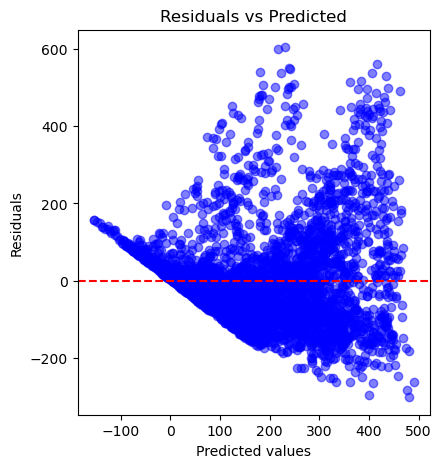

In [349]:
# Task 4: Baseline Model - Linear Regression

baseline_model = LinearRegression()
baseline_model.fit(x_train, y_train)

# predict model with validation set
y_pred_baseline = baseline_model.predict(x_val)

# Evaluating Model 
baseline_mse = mean_squared_error(y_val, y_pred_baseline) 
baseline_mae = mean_absolute_error(y_val, y_pred_baseline) 
baseline_r2 = r2_score(y_val, y_pred_baseline)

print("Mean Squared Error:", baseline_mse)
print("Mean Absolute Error:", baseline_mae)
print("R2 Score", baseline_r2)

residuals = y_val - y_pred_baseline
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_pred_baseline, residuals, color='blue', alpha=0.5)
plt.axhline(0, color='red', linestyle='--')  # Horizontal line at 0
plt.title('Residuals vs Predicted')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')



#### Task 4 Analysis:

Bias:
- From the R2 score of 0.5 it proves that the Linear Regression has high bias and there is proof of underfitting. The linear regression is only seeing about half of the variance in the dataset, and a little less than half is not being captured by the model.


Residuals Plot:
- From the plot, the residuals are not scattered around as they are supposed to be and there is not a good linear fit. There is a clear funnel shape happening meaning that there is low variance and the linear model is not capturing some of the more complex relationships. From the residuals and the bias we can see that the linear model is not complex enough and is not capturing a large part of the dataset. 


Mean Squared Error: 1827.7848814441886
Mean Absolute Error: 26.520543728423476
R2 Score 0.9471619329759604


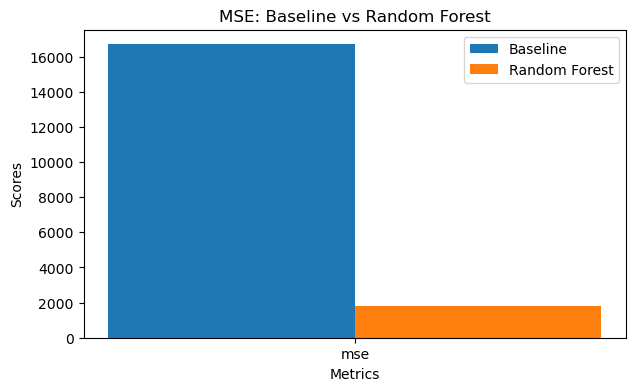

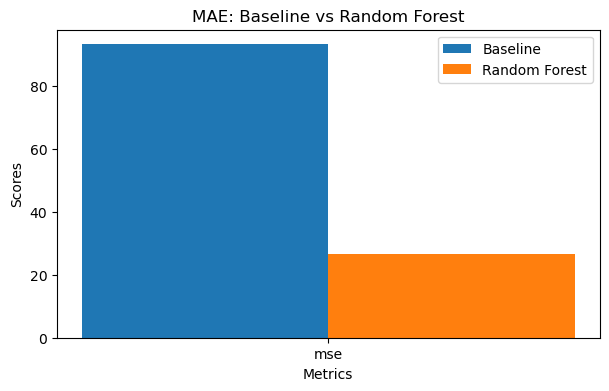

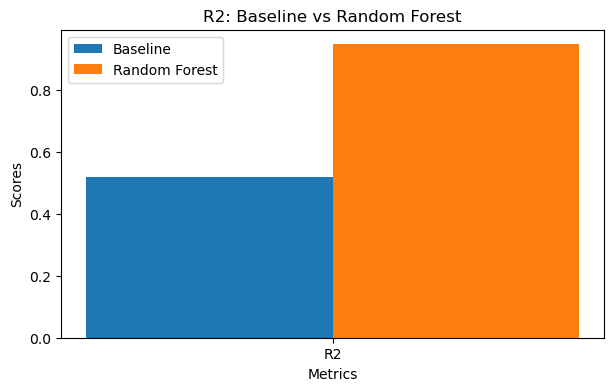

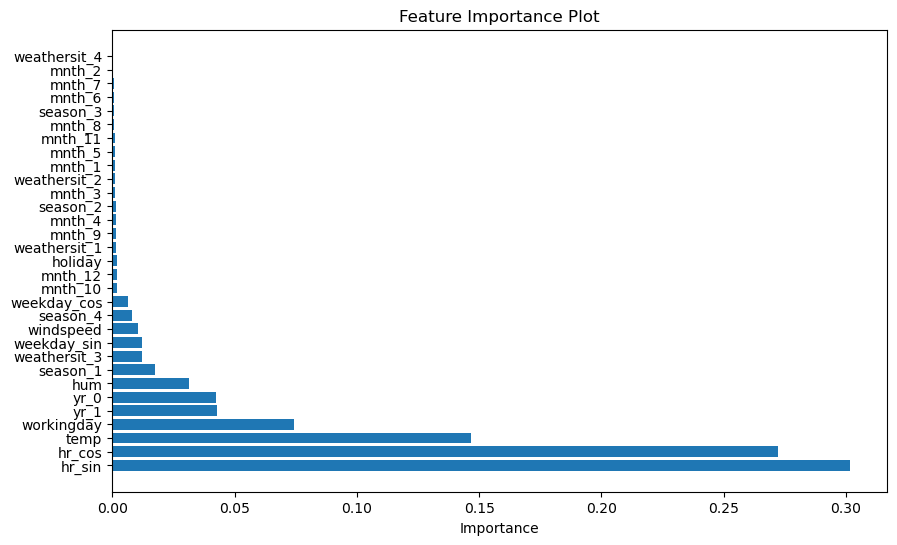

In [392]:
# Task 5: Random Forest Regressor - Model Specification and Training

rf = RandomForestRegressor()
rf.fit(x_train, y_train)

y_pred_rf = rf.predict(x_val)

# Evaluating Model 
rf_mse = mean_squared_error(y_val, y_pred_rf) 
rf_mae = mean_absolute_error(y_val, y_pred_rf) 
rf_r2 = r2_score(y_val, y_pred_rf)

print("Mean Squared Error:", rf_mse)
print("Mean Absolute Error:", rf_mae)
print("R2 Score", rf_r2)


# MSE comparison
mse = ['mse']
x = np.arange(1) 
width = 0.1  
fig, ax = plt.subplots(figsize=(7, 4))
rects1 = ax.bar(x - width/2, baseline_mse, width, label='Baseline')
rects2 = ax.bar(x + width/2, rf_mse, width, label='Random Forest')
ax.set_xticks(x)
ax.set_xticklabels(mse)
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('MSE: Baseline vs Random Forest')
ax.legend()
plt.show()

# MAE Comparison
mae = ['MAE']
x = np.arange(1) 
width = 0.1
fig, ax = plt.subplots(figsize=(7, 4))
rects1 = ax.bar(x - width/2, baseline_mae, width, label='Baseline')
rects2 = ax.bar(x + width/2, rf_mae, width, label='Random Forest')
ax.set_xticks(x)
ax.set_xticklabels(mse)
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('MAE: Baseline vs Random Forest')
ax.legend()
plt.show()

# R2 comparison
mse = ['R2']
x = np.arange(1) 
width = 0.1  
fig, ax = plt.subplots(figsize=(7, 4))
rects1 = ax.bar(x - width/2, baseline_r2, width, label='Baseline')
rects2 = ax.bar(x + width/2, rf_r2, width, label='Random Forest')
ax.set_xticks(x)
ax.set_xticklabels(mse)
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('R2: Baseline vs Random Forest')
ax.legend()
plt.show()

# Feature importance plot
import_features = rf.feature_importances_
feature_names = x_train.columns
indices = np.argsort(import_features)[::-1]
plt.figure(figsize=(10, 6))
plt.title('Feature Importance Plot')
plt.barh(range(len(indices)), import_features[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Importance')
plt.show()


#### Task 5: Analysis
- For the Random Forest Regressor I used default parameters to establish a baseline for this model. I visualized all three metrics side by side with the baseline model. For mean squared error, the random forest is much lower showing that this model is performing much better and having less errors. For mean absolute error, the Random Forest had approx. 26 whereas the baseline model had approx. 93. Finally the R2 score of the random forest is approx. 95%, which is highly accurate and capturing the variance much better then the baseline model.

- For the feature importance plot, hr_cos and hr_sin are two of the top indicators which makes sense because more rentals would take place during daytime hours compared to the middle of the night. The third top indicator is temp which makes sense as well because more rentals would take place in the warmer weather compared to freezing cold. 

Index(['holiday', 'workingday', 'temp', 'hum', 'windspeed', 'hr_sin', 'hr_cos',
       'weekday_sin', 'weekday_cos', 'season_1', 'season_2', 'season_3',
       'season_4', 'weathersit_1', 'weathersit_2', 'weathersit_3',
       'weathersit_4', 'yr_0', 'yr_1', 'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4',
       'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11',
       'mnth_12'],
      dtype='object')
Index(['holiday', 'workingday', 'temp', 'hum', 'windspeed', 'hr_sin', 'hr_cos',
       'weekday_sin', 'weekday_cos', 'season_1', 'season_2', 'season_3',
       'season_4', 'weathersit_1', 'weathersit_2', 'weathersit_3',
       'weathersit_4', 'yr_0', 'yr_1', 'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4',
       'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11',
       'mnth_12'],
      dtype='object')
Mean Squared Error: 4643.01713322112
Mean Absolute Error: 47.418946149578964
R2 Score 0.9474934859296957


Text(0, 0.5, 'Residuals')

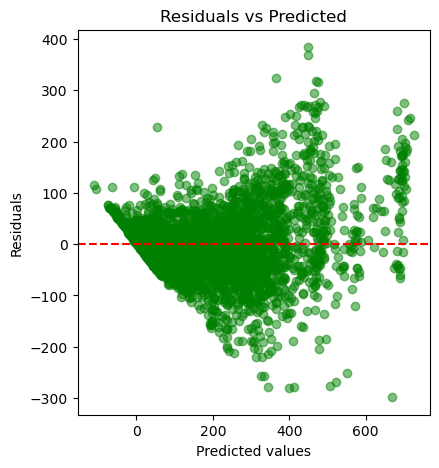

In [352]:
# Task 6: Gradient Boosting Regressor - Model Specification and Training

gbr = GradientBoostingRegressor()
gbr.fit(x_train, y_train)

y_pred_gbr = gbr.predict(x_val)

# Evaluating Model 
gbr_mse = mean_squared_error(y_val, y_pred_gbr) 
gbr_mae = mean_absolute_error(y_val, y_pred_gbr) 
gbr_r2 = r2_score(y_val, y_pred_rf)

print("Mean Squared Error:", gbr_mse)
print("Mean Absolute Error:", gbr_mae)
print("R2 Score", gbr_r2)

# Plot residuals 
gbr_residuals = y_val - y_pred_gbr
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_pred_gbr, gbr_residuals, color='green', alpha=0.5)
plt.axhline(0, color='red', linestyle='--')  
plt.title('Residuals vs Predicted')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')



#### Task 6 Analysis
- For the Gradient Boosting Regressor I started with default parameters to establish a baseline. The Mean Squared Error was 4643, mean absolute error was 47 and R2 score was around 0.95. Here the gradient boosting regressor is not performing as well as the Random Forest. The mean squared error was over 2000 points higher, the mean absolute error was around 20 points higher as well. Though the R2 score was around the same. Due to the R2 being about the same when the other metrics are worse (higher) there could be evidence of overfitting.

Residuals Plot
- In the residual plot there is still somewhat of a shape of a funnel but once it gets to the higher values there is more variance. We can see that the lower values have residuals that are mainly positive and have less variance. This plot shows that there is still bias present within the model. The model is capturing some of the relationship specifically with the higher values (hence the r2 score), but the MAE and MSE show that there are still errors with this model. +

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Mean Squared Error: 1776.1527487156907
Mean Absolute Error: 26.113514802180937
R2 Score 0.9486545277103839


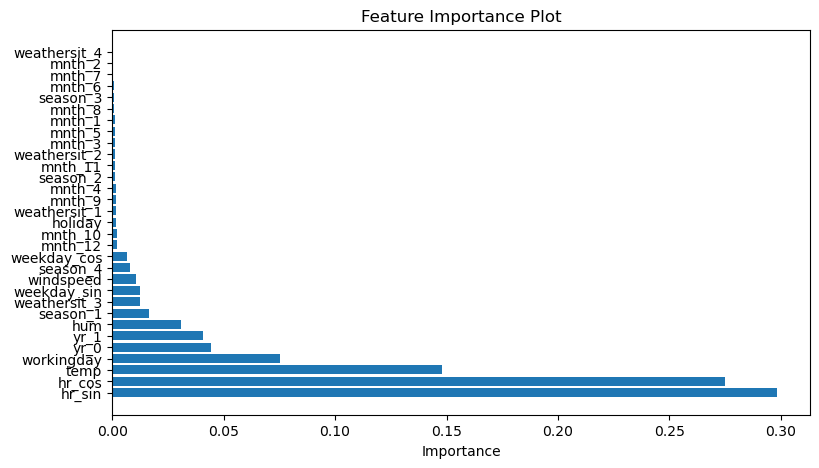


Best Random Forest (Randomized Search) Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30} 


In [353]:
# Task 7: Hyperparameter Tuning - Part 1

# Tune Random Forest Regressor 

# Define hyperparameter grid
rf_param_grid = {
"n_estimators": [50, 100, 200],
"max_depth": [None, 10, 20, 30],
"min_samples_split": [2, 5, 10],
"min_samples_leaf": [1, 2, 4],
}

ts = TimeSeriesSplit(n_splits=5)

# define random search
rf_random_search = RandomizedSearchCV(
estimator=rf,
param_distributions=rf_param_grid,
n_iter=50,
scoring="r2",
cv=ts,
n_jobs=-1,
verbose=1,
random_state=42,
)


rf_random_search.fit(x_train, y_train)
y_pred_rf_random = rf_random_search.predict(x_val)

# Evaluation
rs_mse = mean_squared_error(y_val, y_pred_rf_random) 
rs_mae = mean_absolute_error(y_val, y_pred_rf_random) 
rs_r2 = r2_score(y_val, y_pred_rf_random)

print("Mean Squared Error:", rs_mse)
print("Mean Absolute Error:", rs_mae)
print("R2 Score", rs_r2)

# Feature importance plot
best_rs_model = rf_random_search.best_estimator_
importances = best_rs_model.feature_importances_

# Feature importance plot
rs_features = best_rs_model.feature_importances_
rs_feature_names = x_train.columns
indices = np.argsort(rs_features)[::-1]
plt.figure(figsize=(9, 5))
plt.title('Feature Importance Plot')
plt.barh(range(len(indices)), rs_features[indices], align='center')
plt.yticks(range(len(indices)), [rs_feature_names[i] for i in indices])
plt.xlabel('Importance')
plt.show()

# Printing best hyperparameters 
print("\nBest Random Forest (Randomized Search) Parameters: %s "
% rf_random_search.best_params_
)



#### Task 7 Analysis - Random Forest Regressor

Best Parameters:
- n_estimators: 200
- min_samples_split: 2
- min_samples_leaf:
- max_depth: 30

After tuning the Random Forest Regressor using Randomized Search CV, the model is performing slightly better than before tuning. MSE decreased to the 1700s, MAE decreased by 0.1, and R2 score improved by around 0.1%. The hyperparameter tuning helped decrease the errors and maintained a high R2 score, capturing slightly more of the variance. The improvements are somewhat small so this could mean that the initial parameters were close to optimal already. 


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

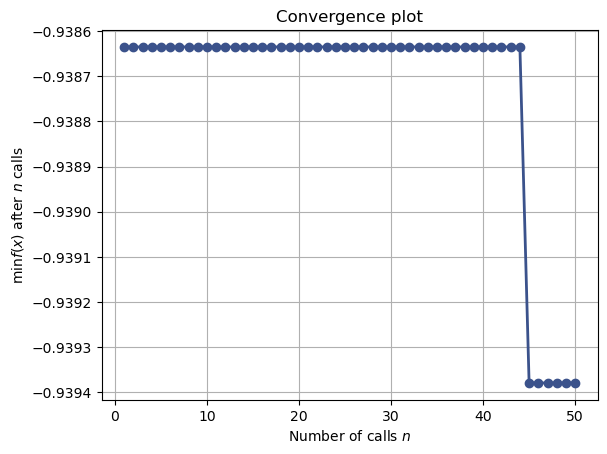

Mean Squared Error: 1465.402877016131
Mean Absolute Error: 23.51924027228346
R2 Score 0.9576377634922663

Best Gradient Boosting (Bayesian Optimization) Parameters: OrderedDict({'learning_rate': 0.021574117369730722, 'max_depth': 10, 'n_estimators': 300, 'subsample': 0.5})


In [354]:
# Task 7: Hyperparameter Tuning - Part 2

# Tune Gradient Boosting Regressor

# Define hyperparameter search space
gbr_param_space = {
"n_estimators": (50, 300), 
"learning_rate": (0.01, 1.0, "log-uniform"),
"max_depth": (3, 10), 
"subsample": (0.5, 1.0, "uniform"),
}

bayes_search = BayesSearchCV(
    estimator=gbr,
    search_spaces=gbr_param_space,
    n_iter=50, 
    scoring="r2",
    cv=ts,
    n_jobs=-1,
    random_state=42,
    verbose=1,
)

# Fit the Bayesian optimization search on the training data.
bayes_search.fit(x_train, y_train)

# Make predictions on the validation set.
bs_y_pred = bayes_search.predict(x_val)

# Visualizing convergence
plot_convergence(bayes_search.optimizer_results_[0]) 
plt.show()

# Evaluation
bs_mse = mean_squared_error(y_val, bs_y_pred) 
bs_mae = mean_absolute_error(y_val, bs_y_pred) 
bs_r2 = r2_score(y_val, bs_y_pred)

print("Mean Squared Error:", bs_mse)
print("Mean Absolute Error:", bs_mae)
print("R2 Score", bs_r2)

# Best Bayes Model
best_bayes = bayes_search.best_estimator_

# Printing best hyperparameters
print(
"\nBest Gradient Boosting (Bayesian Optimization) Parameters: %s"
% bayes_search.best_params_
)



#### Task 7 Analysis - Bayes Search CV

Best Parameters:
- learning rate: 0.021574117369730722
- max_depth: 10
- n_estimators: 300
- subsample: 0.5

After hyperparameter tuning the Gradient Boosting regression, the model improved and benefited more than the Random Forest model. The mean squared error decreased by almost 3000, the mean absolute error descreased by 20+, and the R2 score increased by about 1%. This model had a greater impact to the hyperparameter tuning than Random Forest and improved in decreasing errors substantially. I think this hypertuning was more successful because it learns from the past steps whereas Random Search is taking random samples. 

Convergence Plot
- In this convergence plot we can see that the algorithm successfully found more optimal parameters in the grid around call 44. There is a sharp improvement showing that the found parameters in the space resulted in a better hyperparameter configuration and better performance of the model. 

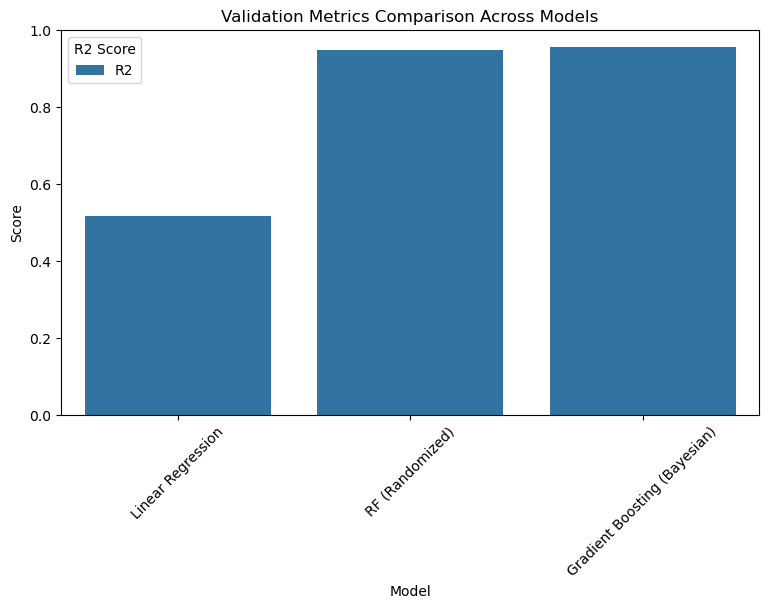

Random Forest CV: Mean=0.9224087649082199, Std=0.019876400331581355
Bayesian Search CV: Mean=0.9392044074845849, Std=0.01265142813648987


In [355]:
# Task 7: Hyperparameter Tuning - Cross Validating

# Create a DataFrame that holds R2
val_comparison = pd.DataFrame(
    { "Model": ["Linear Regression","RF (Randomized)","Gradient Boosting (Bayesian)",],
     "R2": [baseline_r2, rs_r2, bs_r2,]
    }
)

# Melt the DataFrame 
val_comparison_melted = val_comparison.melt(
id_vars='Model',
value_vars=['R2'],
var_name='R2 Score',
value_name='Score'
)

# Create a bar plot to compare R2
plt.figure(figsize=(9, 5))
sns.barplot(x='Model', y='Score', hue='R2 Score', data=val_comparison_melted)
plt.title("Validation Metrics Comparison Across Models")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()

# Random Forest CV
rf_cv_r2 = cross_val_score(best_rs_model, x_train, y_train, cv=ts, scoring='r2')
print(f"Random Forest CV: Mean={rf_cv_r2.mean()}, Std={rf_cv_r2.std()}")

# Bayes CV
bayes_cv = cross_val_score(best_bayes, x_train, y_train, cv=ts, scoring='r2')
print(f"Bayesian Search CV: Mean={bayes_cv.mean()}, Std={bayes_cv.std()}")

#### Task 7 Analysis Part 3

Cross Validation
- The Random Forest had a mean R2 score of 92% whereas the Bayes Search CV had a mean score of 93%. The Bayes Search algorithm consistently had a higher R2 score capturing more of the dataset. For the standard deviation, Bayes search had around 1.2% whereas Random Forest was around 1.9%. This shows that Bayes Search is more consistent and varies less in its performance, which could mean it is better at generalizing due to its ability to vary less when evaluating different parts of the data. Comparing the R2 scores to the baseline, both of the hypertuned models are performing significantly better than the baseline and capturing more of the dataset, leading to better generalization.


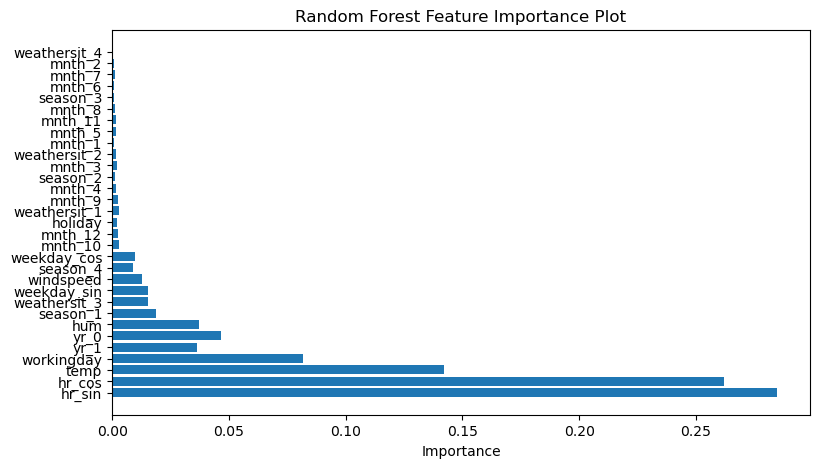

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [396]:
# Task 8: Iterative Evaluation and Refinement

# Plot feature importance

# Bayes 
important_features = best_bayes.feature_importances_
feature_names = x_train.columns
indices = np.argsort(import_features)[::-1]
plt.figure(figsize=(9, 5))
plt.title('Random Forest Feature Importance Plot')
plt.barh(range(len(indices)), important_features[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Importance')
plt.show()


# try adding interaction
x_train_refined = x_train.copy()
x_val_refined = x_val.copy()
x_test_refined = x_test.copy()

x_train_refined['temp_x_hum'] = x_train['temp'] * x_train['hum']
x_val_refined['temp_x_hum'] = x_val['temp'] * x_val['hum']
x_test_refined['temp_x_hum'] = x_test['temp'] * x_test['hum']

# try dropping features
x_train_refined.drop(columns=['weathersit_4', 'mnth_2', 'mnth_1'], inplace=True)
x_val_refined.drop(columns=['weathersit_4', 'mnth_2', 'mnth_1'], inplace=True)

# retrain with changesdwq
bayes_search_refine = BayesSearchCV(
    estimator=gbr,
    search_spaces=gbr_param_space,
    n_iter=50, 
    scoring="r2",
    cv=ts,
    n_jobs=-1,
    random_state=42,
    verbose=1,
)


bayes_search_refine.fit(x_train_refined, y_train)
refined_pred = bayes_search_refine.predict(x_val_refined)
print('R2: ', r2_score(y_val, refined_pred))   




#### Task 8: Analysis and Documentation

Iterations and Refinement:
- One of the first things I changed to try to improve my model was in my cv for the cross_val_score and when defining my hyperparameter models I was using 5 folds, I decided to change to a TimeSeriesSplit with 5 folds to try and preserve temporal order because I did not do that in splitting of the data. This was also to try to avoid data leakage. I also found that there was data leakage when I was encoding hr and weekday because I was accessing hr and weekday of the entire dataframe and not the specific sets like x_train.

Retuning
- I added an interaction with temp x hum. I also dropped the bottom three least important features based on the important features of the Bayes Search CV to see if this had an impact. The R2 score before retuning was 0.9559013606327186 and after was 0.9544200443000506
- Since there was little to no improvement I decided not to include the interaction or drop any columns in the final model selection and testing. 

In [397]:
# Task 9: Final Model Selection and Testing

# mapping model names to their r2 scores
model_performance = {
"Linear Regression": baseline_r2,
"RF": rs_r2,
"Bayes Search": bs_r2,
}

# Choose the model with the highest r2 score
best_model_name = max(model_performance, key=model_performance.get)
print("\nSelected Best Model based on Validation Accuracy:", best_model_name)
      
# Combine the training and validation sets 
x_train_combined = np.vstack([x_train, x_val])
y_train_combined = np.concatenate([y_train, y_val])

# Based on the best model name, select the corresponding estimator
if best_model_name == "Linear Regression":
    final_model = baseline_model.best_estimator_
elif best_model_name == "RF":
    final_model = rf_random_search.best_estimator_
elif best_model_name == "Bayes Search":
    final_model = bayes_search.best_estimator_
else:
    raise ValueError("Unexpected model selection.")

# Retrain the final model on the combined training data.
final_model.fit(x_train_combined, y_train_combined)

# Predict on the test set.
test_pred_final = final_model.predict(x_test)

test_final_mse = mean_squared_error(y_test, test_pred_final)
test_final_mae = mean_absolute_error(y_test, test_pred_final)
test_final_r2 = r2_score(y_test, test_pred_final)

print("MSE:", test_final_mse)
print("MAE:", test_final_mae)
print("R2 Score:", test_final_r2) 






Selected Best Model based on Validation Accuracy: Bayes Search
Index(['holiday', 'workingday', 'temp', 'hum', 'windspeed', 'hr_sin', 'hr_cos',
       'weekday_sin', 'weekday_cos', 'season_1', 'season_2', 'season_3',
       'season_4', 'weathersit_1', 'weathersit_2', 'weathersit_3',
       'weathersit_4', 'yr_0', 'yr_1', 'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4',
       'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11',
       'mnth_12'],
      dtype='object')
MSE: 1660.445254219577
MAE: 23.604516830804666
R2 Score: 0.9511021139494229
